In [19]:
import deeplake
from matplotlib import pyplot as plt
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.metrics import accuracy, specificity
from Network.Unet import Custom2DUnet
from torch.nn.functional import one_hot
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors as mcolors
skip = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# CUDA_VISIBLE_DEVICES=3 python3 main.py -v FedAvgDrive --data-dir None  -cd None -e 4 -r 30 -bs 1 -m "fedavg" -t "drive"

In [20]:
def ploting(fedavg, fedprox, fedref, title="MNIST Classification", zoom_min = 20, zoom_max=25, inset=True, metric="loss", minimum_y=0):
    # 예시 데이터
    tableau_colors = list(mcolors.TABLEAU_COLORS.values())
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fedavg[metric], marker=".",linestyle="--",label="fedavg", color=tableau_colors[0], alpha=1)
    ax.plot(fedprox[metric], marker=".", linestyle="--" ,label="fedprox(mu=0.5)", color=tableau_colors[1], alpha=0.7)
    for i,l in enumerate(fedref):
        ax.plot(l[metric], marker=".", label=l["label"], color=tableau_colors[i+2], linestyle="--")

    # 메인 축 설정
    ax.set_title(title)
    ax.set_xlabel("Round")
    ax.set_ylabel(metric)
    ax.legend()
    # 🔍 확대 구간 설정 (마지막 x값 근처, 예: x > 90)
    x_zoom_min = zoom_min
    x_zoom_max = zoom_max

    # inset 축 생성
    if inset:
        axins = inset_axes(ax, width="30%", height="40%", loc='lower right')
        axins.plot(fedavg[metric], color =tableau_colors[0], label = "fedavg", marker=".", alpha=1, linestyle="--")
        axins.plot(fedprox[metric], color =tableau_colors[1], label = "fedprox", linestyle="--", marker= ".", alpha=0.7)
        for i,l in enumerate(fedref):
            axins.plot(l[metric], label=l["label"], color=tableau_colors[i+2], linestyle="--", marker=".")

        alp = fedavg[metric][zoom_min:zoom_max+1].to_list() + fedprox[metric][zoom_min:zoom_max+1].to_list()
        for l in fedref:
            alp = alp + l[metric][zoom_min:zoom_max+1].to_list()

        axins.set_xlim(x_zoom_min, x_zoom_max)
        #확대된 y축 범위도 지정하면 보기 쉬움
        #y_zoom = y[(x >= x_zoom_min) & (x <= x_zoom_max)]
        axins.set_ylim(bottom=min(alp), top = max(alp))
        
        # 확대된 영역 표시선 연결
        ax.indicate_inset_zoom(axins)
    ax.legend(fontsize=11)

    minimum = [fedavg[metric].min(), fedprox[metric].min()] + [ s[metric].min() for s in fedref]
    minimum = min(minimum)
    ax.set_ylim(bottom=minimum-minimum_y)
    fig.show()
    

In [34]:
diceLoss = smp.losses.DiceLoss(
   mode="multiclass",          # For multi-class segmentation
   classes=None,               # Compute the loss for all classes
   log_loss=False,             # Do not use log version of Dice loss
   from_logits=True,           # Model outputs are raw logits
   smooth=1e-5,                # A small smoothing factor for stability
   ignore_index=None,          # Don't ignore any classes
   eps=1e-7                    # Epsilon for numerical stability
)
class Hausdolf95(torch.nn.Module):
    def __init__(self):
        super(Hausdolf95, self).__init__()
        self.distancef = torch.nn.PairwiseDistance()
    def distance(self, x, y):
        return self.distancef(x, y)
        
    def forward(self, x, y):
        maximum_d=torch.max(self.distance(x, y))
        return maximum_d
hausdolf95 = Hausdolf95()
jaccardf = smp.losses.JaccardLoss(
   mode="multiclass",          # For multi-class segmentation
   classes=None,               # Compute the loss for all classes
   log_loss=False,             # Do not use log version of Dice loss
   from_logits=True,           # Model outputs are raw logits
   smooth=1e-5,                # A small smoothing factor for stability          
   eps=1e-7
)
def evaluation(net, loader, diceLoss, HF95, jaccard,DEVICE):
    net.eval()
    net.to(DEVICE)
    dicef= diceLoss.to(DEVICE)
    hf95f = HF95.to(DEVICE)
    jaccardf = jaccard.to(DEVICE)
    dice = 0
    hf95 = 0
    jacc = 0
    length = len(loader)
    for sample in loader:
        X= torch.stack([torch.from_numpy(s["x"]) for s in sample], 0)
        Y= torch.stack([torch.where(torch.from_numpy(s["y"]).squeeze(), 0.0, 1.0).type(torch.int64) for s in sample], 0)
        X = X.permute(0,3,1,2)  # Change to (C, H, W) format
        Y = Y.permute(0,3,1,2) 
        out = net(X.type(torch.float32).to(DEVICE))
        out = out.sigmoid()
        dice += (1-dicef(out.to(DEVICE), Y.argmax(dim=1).type(torch.int64).to(DEVICE))).item()
        hf95 += hf95f(out.to(DEVICE), Y.type(torch.float32).to(DEVICE)).item()
        jacc += (1-jaccardf(out.to(DEVICE), Y.argmax(dim=1).type(torch.int64).to(DEVICE))).item()
    return {"dice": dice/length, "hf95":hf95/length, 'jaccard': jacc/length}


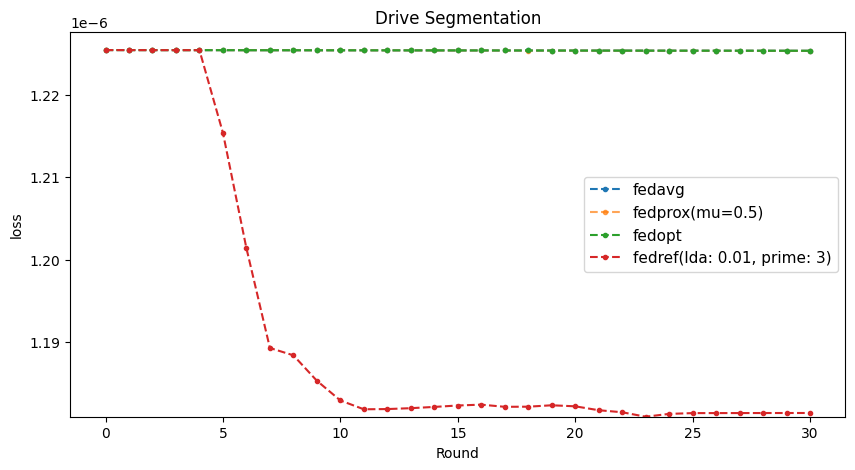

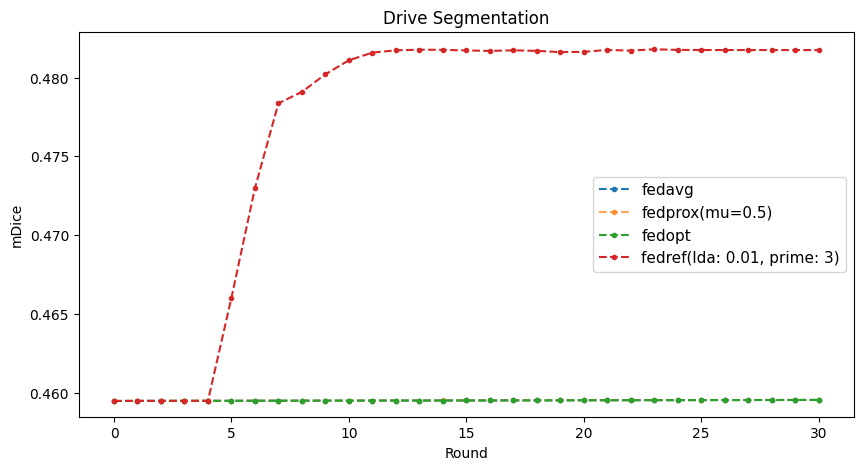

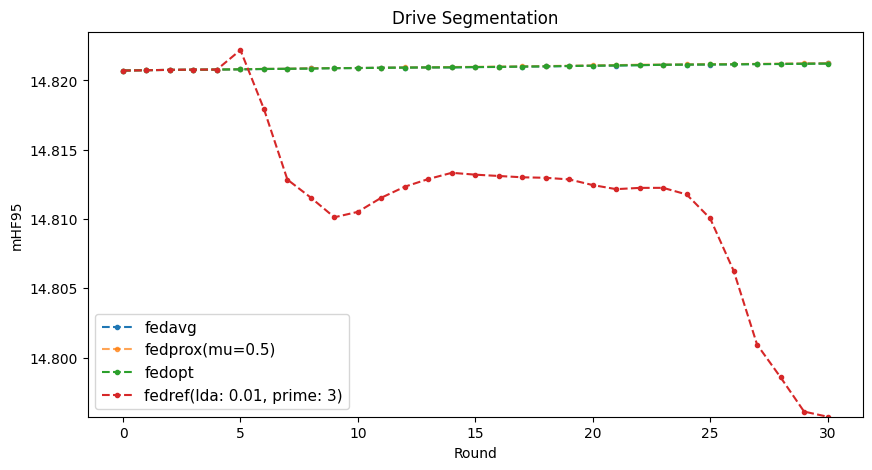

In [22]:
fedavg = pd.read_csv("Result/fedavg/fedavg_drive.csv")
fedprox = pd.read_csv("Result/fedprox/fedprox_drive.csv")
fedopt = pd.read_csv("Result/fedopt/fedopt_drive.csv")
fedref1 = pd.read_csv("Result/fedref/fedref_drive_lda0.1_p3.csv")
ploting(fedavg, fedprox, [{"loss": fedopt["loss"], "label": "fedopt"}, {"loss": fedref1["loss"], "label": "fedref(lda: 0.01, prime: 3)"}], title="Drive Segmentation", zoom_min=20, zoom_max=25, inset=False)
ploting(fedavg, fedprox, [{"mDice": fedopt["mDice"], "label": "fedopt"}, {"mDice": fedref1["mDice"], "label": "fedref(lda: 0.01, prime: 3)"}], title="Drive Segmentation", zoom_min=20, zoom_max=25, inset=False, metric="mDice", minimum_y= 0.001)
ploting(fedavg, fedprox, [{"mHF95": fedopt["mHF95"], "label": "fedopt"}, {"mHF95": fedref1["mHF95"], "label": "fedref(lda: 0.01, prime: 3)"}], title="Drive Segmentation", zoom_min=20, zoom_max=25, inset=False, metric="mHF95")

In [35]:
testset = deeplake.load("hub://activeloop/drive-test")
test_loader = testset.pytorch(batch_size=4, shuffle=False, collate_fn=lambda x: x, transform=lambda x: {"x": x["rgb_images"], "y": x["masks"]})
net = Custom2DUnet(3, 2, False, layer_order="cr", f_maps=32, num_groups=4, num_levels=4, conv_padding=1, conv_upscale=2, upsample='default', dropout_prob=0.1)
net.to(DEVICE)

hub://activeloop/drive-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/drive-test


Custom2DUnet(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (2): Encoder(
      (pooling): MaxPool2d(kernel_size=2, stride=2, pad

In [36]:
net.load_state_dict(torch.load("Models/FedAvgDrive/net.pt"))
net.eval()
evaluation(net, test_loader, diceLoss, hausdolf95, jaccardf, DEVICE)

/tmp/ipykernel_2961197/878005566.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("Models/FedAvgDrive/net.pt"))


{'dice': 0.4595349669456482,
 'hf95': 14.821224594116211,
 'jaccard': 0.30231763124465943}

In [37]:
net.load_state_dict(torch.load("Models/FedProxDrive/net.pt"))
evaluation(net, test_loader, diceLoss, hausdolf95, jaccardf, DEVICE)


/tmp/ipykernel_2961197/527428745.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("Models/FedProxDrive/net.pt"))


{'dice': 0.4595371842384338,
 'hf95': 14.821236991882325,
 'jaccard': 0.302319610118866}

In [38]:
net.load_state_dict(torch.load("Models/FedOptDrive/net.pt"))
evaluation(net, test_loader, diceLoss, hausdolf95, jaccardf, DEVICE)

/tmp/ipykernel_2961197/3100204949.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("Models/FedOptDrive/net.pt"))


{'dice': 0.4595334053039551,
 'hf95': 14.821211433410644,
 'jaccard': 0.30231618881225586}

In [41]:
net.load_state_dict(torch.load("Models/FedRefDrive/net_lda0.1_p3.pt"))
evaluation(net, test_loader, diceLoss, hausdolf95, jaccardf, DEVICE)

/tmp/ipykernel_2961197/2962777591.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("Models/FedRefDrive/net_lda0.1_p3.pt"))


{'dice': 0.48174272775650023,
 'hf95': 14.795726776123047,
 'jaccard': 0.32272944450378416}